# Perceptual decision making (4)

In this section, we introduce how the standard drift-diffusion model(DDM) can be used to fit real data.

In the standard DDM, sensory evidence in each frame follows a Gaussian distribution
$$
e = N(u, \sigma^2)
$$
The visibility of stimuli becomes higher as coherence increases. In theory, a higher coherence provides stronger sensory evidence in each frame. Assuming $\sigma=0.1$, we further assume a linear relationship between the mean $u$ of the distribution and cohernece level $coh$
$$
u = k*coh
$$

Let's simulate a drift-diffusion process. We have two settings:
* The answer is correct if the accumulated evidence reaches the upper bound, and vice verse for the lower bound
* Sensory evidence starts at the middle point between the upper and lower bounds.

(0.0, 3.0)

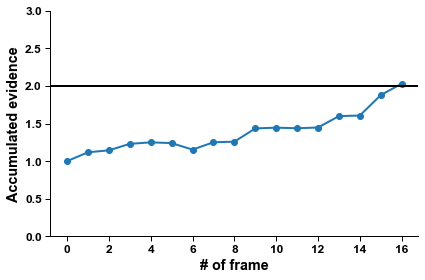

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt 

B = 2 # upper bounds, assuming lower bounds is 0
k = 1 # linear coeffient between drift rate and coherence
coh = 0.064 # choose one coefficient
driftRate = k * coh # drift rate
sigma = 0.1

evidence = B/2
accumEvidence = []
accumEvidence.append(evidence)

i = 0
while np.abs(evidence) < B:
    # update frame number
    i = i+1
    # update evidence
    # for every frame, we sample a 
    evidence = evidence + norm.rvs(loc=driftRate, scale=sigma, size=1)[0]
    
    accumEvidence.append(evidence)

plt.plot(np.arange(i+1), accumEvidence, '-o')
plt.axhline(B, color='k', label='Decision boundary')
plt.xlabel('# of frame')
plt.ylabel('Accumulated evidence')
plt.ylim([0, B+1])

The standard DDM has four free paremters:
* drift coefficient: $k$, $u = k * coh$ 
* decision boundary: $B$
* initial bias: $alpha$ (default: 0.5). In some scenarios, the starting point could be biased towards either the upper or the lower bounds, indicating the prior bias in decision-making processes.
* non-decision time(ndt): the whole decision process includes both drift-diffusion process and the duration of other non-decision processes (e.g., the time for a button press)

In a typical experiment, we know the three varibles in each trial:
* coherence 
* Correct/wrong($c_i$=1/0)
* Reaction time (ms), $rt_i$

We use the data to infere the four free parameters of each subject. Let $\theta=(k, B, a, ndt)$, where $k$ is drift coefficient, $B$ is decision boundary，$a$ is initial bias, $ndt$ is non-decision time.

We used the method of maximum likelihood estimate to obtain the parameters
$$
p(rt_i|\theta, coh_i, c_i)
$$

In [2]:
from scipy.optimize import minimize
from ddm import ddmpdf # ddm probility density function

Let's load the data

In [3]:
data = np.loadtxt('exampledata.txt')
print(data.shape)

(300, 3)


The example data is a 300 (trials) x 3 array.
* 1st column: coherence
* 2nd column: reaction time
* 3rd column: correct/wrong (1/0)

In [4]:
# define a negative log-likelihood objective functions
def negloglikeli(params):
    '''
    <params>:(4,) array, drift coefficient, decision boundary, initial bias, non-decision time
    '''
    k = params[0] # drift coefficient
    B = params[1] # decision boundary
    a = params[2] # initial bias (0, 1)
    ndt = params[3] # non-decision time

    nTrial = data.shape[0] # how many trials
    pp = np.empty(nTrial)
    for i in range(nTrial): # loop trial
        pp[i] = ddmpdf(k, a, B, ndt, coh=data[i, 0], rt=data[i, 1], correct=data[i, 2])

    pp=0.999*pp + np.finfo(np.float32).eps # to avoid p=0
    return -np.log(pp).sum() # take log, sum，add negative

Let's optimize this objective function to obtain the fitted parameters

In [1]:
res = minimize(fun=negloglikeli, x0=(1.6, 2.3, 0.5, 0.01), bounds=((0, 20), (0, 5), (0, 1), (0, 1))) # use bounds to constrain the range of the parameters

print('\nfitted drift coefficient is ', res.x[0])
print('fitted decision boundary is ', res.x[1])
print('fitted initial bias is ', res.x[2])
print('fitted nondecision time is ', res.x[3])

NameError: name 'minimize' is not defined

# Summary
* The standard DDM assumes a linear relationship between drift rate and coherence
* We can use a predefined probility density function to calculate log likelihood of data given parameter
* We use the method of maximum likelihood estimation to infer free paremeters
 